In [ ]:
# # %pip install nengo_dl
# # %pip install --force-reinstall -v nengo==3.2 
# # %pip install --force-reinstall -v tensorflow==2.11
# !(mkdir temp_datasets; \
#   cd temp_datasets; \
#   wget https://biometrics.nist.gov/cs_links/EMNIST/gzip.zip; \
#   unzip gzip.zip; cd gzip; gunzip emnist-balanced-train-images-idx3-ubyte.gz; \
#   gunzip emnist-balanced-train-labels-idx1-ubyte.gz)

In [1]:
import numpy as np
import tensorflow as tf
import os
import nengo_dl
import matplotlib.pyplot as plt

2024-06-03 18:10:14.991552: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-03 18:10:15.126308: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2024-06-03 18:10:15.126330: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-06-03 18:10:15.839315: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No s

In [11]:
import struct
from string import ascii_uppercase
from segmention import segmentoutletters

def read_images(file_path):
    with open(file_path, 'rb') as f:
        magic, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows, cols)
    return images

def read_labels(file_path):
    with open(file_path, 'rb') as f:
        magic, num_labels = struct.unpack(">II", f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

def read_validation_data(n_steps=30):
    labels = {
            "(BARCODE)0003": "AT_02001/2",
            "(BARCODE)0007": "AT_02001/6",
            "(BARCODE)0015": "AT_02002/4",
            "BG_0005": "BG_01001/5",
            "BG_0012": "BG_01002/2",
            "BG_0014": "BG_01002/4",
        }

    a = list(range(36)) + [1, 1]
    b = list(map(str, range(10))) + list(ascii_uppercase) + ["/", "_"]
    convert_classes = dict(zip(b, a))

    for i, name in zip(range(6), os.listdir("Dane")):
        segmentation_output, _ = segmentoutletters(name)
        segmentation_labels = np.array([convert_classes[i] for i in labels[name[:-4]]])
        validation_images = np.vstack((validation_images, segmentation_output)) if i else segmentation_output
        validation_labels = np.vstack((validation_labels, segmentation_labels.reshape((-1, 1)))) if i else segmentation_labels.reshape((-1, 1))
    
    validation_labels = np.tile(validation_labels[:, :, None], (1, n_steps, 1))
    return validation_images, validation_labels

def preprocess(images, labels, n_steps=1, portion=1):
    # choose only a portion of the samples, delete lowercase letters
    indices = []
    for i in range(36):
      idcs = np.where(labels == i)[0][::portion]
      indices += list(idcs)
    images = images[indices, ...]
    images = np.moveaxis(images, 2, 1)
    labels = labels[indices]
    # flatten images
    images = images.reshape((images.shape[0], -1))
    # add time
    images = np.tile(images[:, None, :], (1, n_steps, 1))
    labels = np.tile(labels[:, None, None], (1, n_steps, 1))
    return images, labels

In [12]:

train_images = read_images('datasets/gzip/emnist-balanced-train-images-idx3-ubyte')
train_labels = read_labels('datasets/gzip/emnist-balanced-train-labels-idx1-ubyte')

n_steps = 30
train_images, train_labels = preprocess(train_images, train_labels, 1, 1)
validation_images, validation_labels = read_validation_data(30)
# stack data to be able to evaluate with minibatch_size
validation_images = np.tile(validation_images, (3, 1, 1))
validation_labels = np.tile(validation_labels, (3, 1, 1))

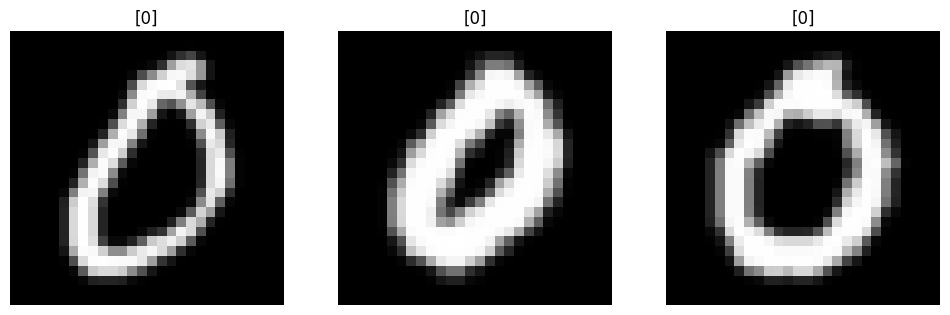

In [13]:
# print(train_labels.shape)
# print(train_images.shape)
# print(validation_labels.shape)
# print(validation_images.shape)
# print(np.max(validation_images))
# print(np.max(train_images))

plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(train_images[i, 0, :].reshape((28, 28)), cmap="gray")
    plt.axis("off")
    plt.title(str(train_labels[i, 0, :]))

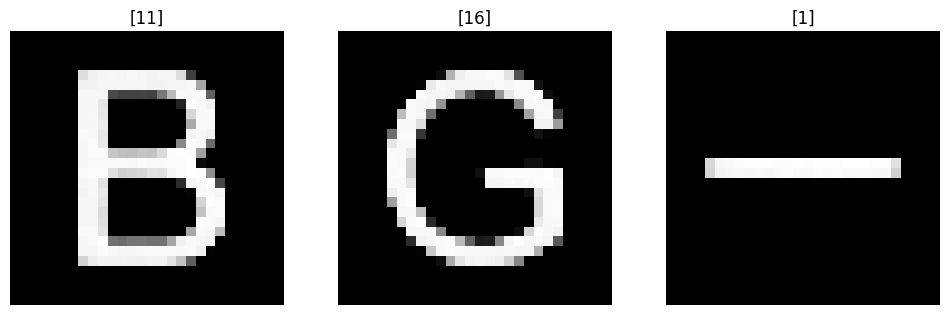

In [14]:
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(validation_images[i, 0, :].reshape((28, 28)), cmap="gray")
    plt.axis("off")
    plt.title(str(validation_labels[i, 0, :]))

In [15]:
from network import net
model, out_p, out_p_filt = net()

In [16]:
def classification_accuracy(y_true, y_pred):
    return tf.metrics.sparse_categorical_accuracy(y_true[:, -1], y_pred[:, -1])
minibatch_size = 180
sim = nengo_dl.Simulator(model, minibatch_size=minibatch_size)
sim.compile(
        optimizer=tf.optimizers.RMSprop(0.001),
        loss={out_p: tf.losses.SparseCategoricalCrossentropy(from_logits=True)},
        metrics=classification_accuracy
    )

|                     Building network (0%)                    | ETA:  --:--:--
|                     Building network (0%)                    | ETA:  --:--:--
|                     Building network (0%)                    | ETA:  --:--:--


/home/bart/Dokumenty/StudiaII/Semestr1/Akceleracja_algorytmów_wizyjnych_w_GPU_i_OpenCL/Projekt/Kod/.venv/lib/python3.10/site-packages/nengo_dl/simulator.py:456: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(


|###                   Building network (5%)                     | ETA: 0:00:05
|###                   Building network (5%)                     | ETA: 0:00:06
|###                   Building network (5%)                     | ETA: 0:00:07
|######               Building network (10%)                     | ETA: 0:00:04
Build finished in 0:00:00
|#                         Optimizing graph                           | 0:00:00
|#             Optimizing graph: operator simplificaton               | 0:00:00
Optimizing graph: operator simplificaton finished in 0:00:00
|#                Optimizing graph: merging operators                 | 0:00:00
Optimizing graph: merging operators finished in 0:00:00
|#                Optimizing graph: ordering signals                  | 0:00:00
Optimizing graph: ordering signals finished in 0:00:00
|#                Optimizing graph: creating signals                  | 0:00:00
Optimizing graph: creating signals finished in 0:00:00
Optimization finished in 0:

In [17]:
# może dodać jakieś zapisywanie statów do pliku, bo jak się tak uczy z przerwami to się nie będzie dało historii wyplowtować
# training loop
max_epochs = 30
patience = 5
history = {'loss' : [], 'val_loss' : [], 'accuracy' : [], "val_accuracy" : []}
RUN_ID = "dropout_1234" # do zmiany przy douczaniu (żeby nienadpisywały się wagi)
prams_dir = "wagi_epoki/"
# sim.load_params(f'wagi_epoki/params_epoch_1_dropout_0')
for epoch in range(max_epochs):
    print(f"Epoch: {epoch}/{max_epochs}")
    stats = sim.fit(train_images, {out_p : train_labels}, epochs=1)
    print("Validation results:")
    val_stats = sim.evaluate(validation_images, {out_p : validation_labels})
    val_loss = val_stats['loss']
    if epoch > 100:
        if history['val_loss'][-patience] < val_loss:
            best_epoch = min(range(epoch-1), key=lambda e: history['val_loss'][e])
            print("Training stopped due to overfitting")
            print(f"Best validation_results at epoch {best_epoch}")
            break
    sim.save_params(prams_dir + f"params_epoch_{epoch}_{RUN_ID}")
    history['loss'].append(stats.history['loss'])
    history['val_loss'].append(val_loss)
    history['accuracy'].append(stats.history['out_p_classification_accuracy'])
    history['val_accuracy'].append(val_stats['out_p_classification_accuracy'])

Epoch: 0/30
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|###           Constructing graph: build stage (4%)              | ETA: 0:00:01
|##############Constructing graph: build stage (23%)             | ETA: 0:00:00
|##############Constructing graph: build stage (38%)             | ETA: 0:00:00
|##############Constructing graph: build stage (42%)             | ETA: 0:00:00
|##############Constructing graph: build stage (61%)             | ETA: 0:00:00
|##############Constructing graph: build stage (90%)######       | ETA: 0:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
Constructing graph: build stage finished in 0:00:00


KeyboardInterrupt: 

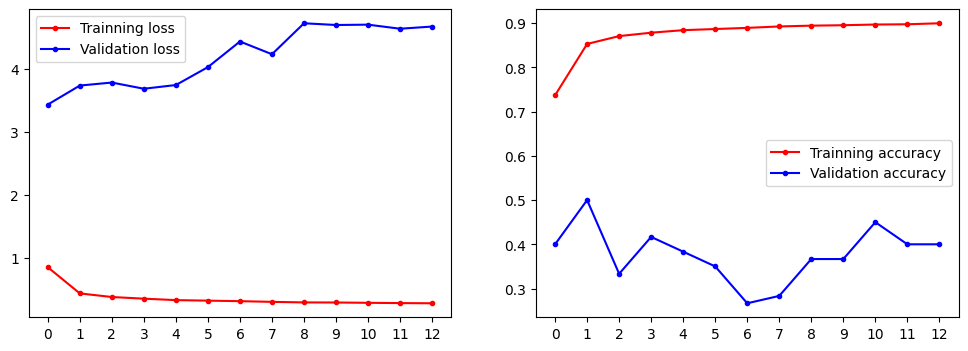

In [9]:
plt.figure(figsize=(12, 4))
ax = plt.subplot(1, 2, 1)
plt.plot(history['loss'], color='red', marker='.')
plt.plot(history['val_loss'], color='blue', marker='.')
plt.xticks(np.arange(epoch))
ax.legend(["Trainning loss", "Validation loss"])

ax = plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], color='red', marker='.')
plt.plot(history['val_accuracy'], color='blue', marker='.')
plt.xticks(np.arange(epoch))
ax.legend(["Trainning accuracy", "Validation accuracy"])

In [ ]:
sim.close()